In [1]:
import torch
from torch import distributions as dist
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from SBM_SDE_classes import *
from obs_and_flow import *
from kalman_filter import *

# Load data

In [31]:
T = 5000
dt = 1.0
obs_CO2 = True    # whether or not to use CO2 obs (True to use CO2, False o/w)
state_ndim = 3    # assumes that obs_ndim = state_ndim + 1, with the last dim being CO2

obs_file = '../generated_data/SCON-C_CO2_logit_short_2022_01_20_08_53_sample_y_t_5000_dt_0-01_sd_scale_0-25.csv'
params_file = '../generated_data/SCON-C_CO2_logit_short_2022_01_20_08_53_sample_y_t_5000_dt_0-01_sd_scale_0-25_rsample.pt'
x0_file = '../generated_data/SCON-C_CO2_logit_short_2022_01_20_08_53_sample_y_t_5000_dt_0-01_sd_scale_0-25_x0_SCON_tensor.pt'
x1_5_file = '../training_pt_outputs/x_eval_iter_110000_warmup_5000_t_5000_dt_1.0_batch_31_layers_5_lr_0.01_decay_step_15000_warmup_lr_1e-06_sd_scale_0.25_SCON-C_CO2_logit_short_2022_03_08_12_39_02.pt'
x2_5_file = '../training_pt_outputs/x_train_iter_110000_warmup_5000_t_5000_dt_1.0_batch_31_layers_5_lr_0.01_decay_step_15000_warmup_lr_1e-06_sd_scale_0.25_SCON-C_CO2_logit_short_2022_03_08_12_39_02.pt'

In [4]:
N = int(T / dt)   # number of discretized time steps WITHOUT THE +1! (remaining of code will use "N + 1")
N, T, dt

(5000, 5000, 1.0)

In [5]:
if obs_CO2:
    obs_ndim = state_ndim + 1
else:
    obs_ndim = state_ndim
obs_error_scale = 0.1
obs_times, obs_vals, obs_errors = csv_to_obs_df(obs_file, obs_ndim, T, obs_error_scale)
obs_times.shape, obs_vals.shape, obs_errors.shape

((1001,), torch.Size([4, 1001]), torch.Size([1, 4]))

In [6]:
obs_vals.shape, obs_errors.shape

(torch.Size([4, 1001]), torch.Size([1, 4]))

In [7]:
obs_vals = obs_vals.T # (t_obs, obs_ndim)
obs_vals.shape

torch.Size([1001, 4])

In [8]:
T_span = torch.linspace(0, T, N + 1)
T_span.shape

torch.Size([5001])

In [9]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

# Observation model parameters
if obs_CO2:
    error_S, error_D, error_M, error_C = obs_errors.squeeze()
    obs_params = {'error_SOC': error_S,
                  'error_DOC': error_D,
                  'error_MBC': error_M,
                  'error_CO2': error_C}
else:
    error_S, error_D, error_M = obs_errors.squeeze()
    obs_params = {'error_SOC': error_S,
                  'error_DOC': error_D,
                  'error_MBC': error_M}

# Transition model parameters
trans_params = {k: torch.as_tensor(v) for k, v in \
                torch.load(params_file).items()}
params = {**trans_params, **obs_params}
params

{'u_M': tensor(0.0018),
 'a_SD': tensor(0.4703),
 'a_DS': tensor(0.4576),
 'a_M': tensor(0.3448),
 'a_MSC': tensor(0.6356),
 'k_S_ref': tensor(0.0004),
 'k_D_ref': tensor(0.0009),
 'k_M_ref': tensor(0.0008),
 'Ea_S': tensor(18.1604),
 'Ea_D': tensor(15.5050),
 'Ea_M': tensor(27.5447),
 'c_SOC': tensor(0.0120),
 'c_DOC': tensor(0.0015),
 'c_MBC': tensor(0.0015),
 'error_SOC': tensor(2.3575),
 'error_DOC': tensor(0.2369),
 'error_MBC': tensor(0.3759),
 'error_CO2': tensor(0.0010)}

In [10]:
#Obtain temperature forcing function.
temp = temp_gen(T_span, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
I_S = i_s(T_span) #Exogenous SOC input function
I_D = i_d(T_span) #Exogenous DOC input function
I_S.shape, I_D.shape

(torch.Size([5001]), torch.Size([5001]))

# Kalman filter

The model has 3 states (SOC, DOC, MBC) and 4 observations (SOC, DOC, MBC, CO2).

## Transition model

The transition distribution of the constant diffusion SCON model is given by:
$$p(\mathbf{x}_t | \mathbf{x}_{t-1}) = N(\mathbf{x}_t |
    \mathbf{x}_{t-1} + \alpha(\mathbf{x}_{t-1}, \boldsymbol{\theta_t}) \Delta t,
    \beta(\mathbf{x}_{t-1}, \boldsymbol{\theta_t}) \Delta t)$$

with drift vector $\alpha$:
$$
\alpha_t =
  \begin{bmatrix}
  I_S^{(t)} + a_{DS} \cdot k_D^{(t)} \cdot D + a_M \cdot a_{MSC} \cdot k_M^{(t)} \cdot M - k_S^{(t)} \cdot S \\
  I_D^{(t)} + a_{SD} \cdot k_S^{(t)} \cdot S + a_M \cdot (1 - a_{MSC}) \cdot k_M^{(t)} \cdot M - (u_M + k_D^{(t)}) \cdot D \\
  u_M \cdot D - k_M^{(t)} \cdot M
  \end{bmatrix}
$$

and diffusion matrix $\beta$:
$$
\beta_t =
  \begin{bmatrix}
  \sigma_S & 0 & 0 \\
  0 & \sigma_D & 0 \\
  0 & 0 & \sigma_M
  \end{bmatrix}
$$

To apply the Kalman filter, we require a linear function of the form:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \mathbf{B}_t \mathbf{u}_t + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise.

Rewriting the SCON transition model this way, we have:
- $\mathbf{A}_t = \mathbf{I} +
    \begin{bmatrix}
    - k_S^{(t)} & a_{DS} \cdot k_D^{(t)} & a_M \cdot a_{MSC} \cdot k_M^{(t)} \\
    a_{SD} \cdot k_S^{(t)} & -(u_M + k_D^{(t)}) & a_M \cdot (1 - a_{MSC}) \cdot k_M^{(t)}  \\
    0 & u_M & -k_M^{(t)}
    \end{bmatrix}\Delta t$
- $\mathbf{B}_t = \mathbf{I}$
- $\mathbf{u}_t=
    \begin{bmatrix}
    I_S \\
    I_D \\
    0 
    \end{bmatrix} \Delta t$
- $\mathbf{Q}_t = \beta_t \Delta t$

## Observation model

The observation distribution of the SCON model is:
$$p(\mathbf{y}_t|\mathbf{x}_t) = N(\mathbf{y}_t|\mathbf{x}_t, \mathbf{R}_t)$$

Expressing it as a linear function of the form: 
$$ \mathbf{y}_t = \mathbf{C}_t \mathbf{x}_{t} + \mathbf{D}_t \mathbf{u}_t + \boldsymbol{\delta}_t$$

where $\boldsymbol{\delta}_t \sim N(\mathbf{0}, \mathbf{R}_t)$ is a Gaussian observation noise, we have:
- $\mathbf{C}_t = \begin{bmatrix}
  1 & 0 & 0 \\
  0 & 1 & 0 \\
  0 & 0 & 1 \\
  (1 - a_{SD}) \cdot k_S^{(t)} & (1 - a_{DS}) \cdot k_D^{(t)} & (1 - a_M) \cdot k_M^{(t)}
  \end{bmatrix}$
- $\mathbf{D}_t = \mathbf{0}$
- $\mathbf{R}_t = \begin{bmatrix}
  \gamma_S & 0 & 0 & 0 \\
  0 & \gamma_D & 0 & 0 \\
  0 & 0 & \gamma_M & 0 \\
  0 & 0 & 0 & \gamma_C \\
  \end{bmatrix}$

In [11]:
# Returns A, B, C, D, Q, R, and u for all time steps 0:T
def get_params_CO2(I_S, I_D, params, temp, temp_ref, state_ndim):
    # Apply temperature-dependent transformation to k_*_ref
    k_S = arrhenius_temp_dep(params['k_S_ref'], temp, params['Ea_S'], temp_ref) # (N, )
    k_D = arrhenius_temp_dep(params['k_D_ref'], temp, params['Ea_D'], temp_ref) # (N, )
    k_M = arrhenius_temp_dep(params['k_M_ref'], temp, params['Ea_M'], temp_ref) # (N, )
    
    # Rewrite drift vector alpha, s.t. x_prev + alpha * dt = A * x_prev + B * u
    A0 = torch.stack([-k_S, params['a_DS'] * k_D, params['a_M'] * params['a_MSC'] * k_M])
    A1 = torch.stack([params['a_SD'] * k_S, -(params['u_M'] + k_D), params['a_M'] * (1 - params['a_MSC']) * k_M])
    A2 = torch.stack([torch.zeros(N + 1), torch.ones(N + 1) * params['u_M'], -k_M])
    A = torch.stack([A0, A1, A2]).permute((2, 0, 1))
    A = torch.eye(state_ndim).unsqueeze(0) + A * dt # (N, 3, 3)
    
    B = torch.eye(state_ndim) # (3, 3)
    u = torch.stack([I_S, I_D, torch.zeros(N + 1)]).T * dt # (N, 3)
    
    # Rewrite diffusion matrix beta, s.t. beta * dt = Q
    Q = torch.diag(torch.tensor([params['c_SOC'],
                                 params['c_DOC'],
                                 params['c_MBC']])) * dt # (3, 3)
    
    # NOTE: Time index on k may be incorrect
    C0 = torch.eye(state_ndim).unsqueeze(0) * torch.ones((len(k_S), 1, 1)) # (N, 3, 3)
    C1 = torch.stack([(1 - params['a_SD']) * k_S,
                      (1 - params['a_DS']) * k_D,
                      (1 - params['a_M']) * k_M]).unsqueeze(0).permute((2, 0, 1)) # (N, 1, 3) 
    C = torch.cat((C0, C1), dim=1) # (N, 4, 3)
    
    D = torch.zeros((state_ndim + 1, state_ndim)) # scalar
    R = torch.diag(torch.tensor([params['error_SOC'],
                                 params['error_DOC'],
                                 params['error_MBC'],
                                 params['error_CO2']]))**2 # (4, 4)
    
    return A, B, C, D, Q, R, u

In [12]:
# Returns A, B, C, D, Q, R, and u for all time steps 0:T
def get_params(I_S, I_D, params, temp, temp_ref, state_ndim):
    # Apply temperature-dependent transformation to k_*_ref
    k_S = arrhenius_temp_dep(params['k_S_ref'], temp, params['Ea_S'], temp_ref) # (N, )
    k_D = arrhenius_temp_dep(params['k_D_ref'], temp, params['Ea_D'], temp_ref) # (N, )
    k_M = arrhenius_temp_dep(params['k_M_ref'], temp, params['Ea_M'], temp_ref) # (N, )
    
    # Rewrite drift vector alpha, s.t. x_prev + alpha * dt = A * x_prev + B * u
    A0 = torch.stack([-k_S, params['a_DS'] * k_D, params['a_M'] * params['a_MSC'] * k_M])
    A1 = torch.stack([params['a_SD'] * k_S, -(params['u_M'] + k_D), params['a_M'] * (1 - params['a_MSC']) * k_M])
    A2 = torch.stack([torch.zeros(N + 1), torch.ones(N + 1) * params['u_M'], -k_M])
    A = torch.stack([A0, A1, A2]).permute((2, 0, 1))
    A = torch.eye(state_ndim).unsqueeze(0) + A * dt # (N, 3, 3)
    
    B = torch.eye(state_ndim) # (3, 3)
    u = torch.stack([I_S, I_D, torch.zeros(N + 1)]).T * dt # (N, 3)
    
    # Rewrite diffusion matrix beta, s.t. beta * dt = Q
    Q = torch.diag(torch.tensor([params['c_SOC'],
                                 params['c_DOC'],
                                 params['c_MBC']])) * dt # (3, 3)
    
    C = torch.eye(state_ndim).unsqueeze(0) * torch.ones((len(k_S), 1, 1)) # (N, 3, 3)
    #C1 = torch.stack([(1 - params['a_SD']) * k_S,
    #                  (1 - params['a_DS']) * k_D,
    #                  (1 - params['a_M']) * k_M]).unsqueeze(0).permute((2, 0, 1)) # (N, 1, 3) 
    #C = torch.cat((C0, C1), dim=1) # (N, 4, 3)
    
    D = torch.zeros((state_ndim, state_ndim)) #torch.zeros((state_ndim + 1, state_ndim)) # scalar
    R = torch.diag(torch.tensor([params['error_SOC'],
                                 params['error_DOC'],
                                 params['error_MBC']]))**2 # (3, 3)
    
    return A, B, C, D, Q, R, u

In [13]:
if obs_CO2:
    A, B, C, D, Q, R, u = get_params_CO2(I_S, I_D, params, temp, temp_ref, state_ndim)
else:
    A, B, C, D, Q, R, u = get_params(I_S, I_D, params, temp, temp_ref, state_ndim)
print(A.shape, C.shape, u.shape)
print(B.shape, D.shape, Q.shape, R.shape)

torch.Size([5001, 3, 3]) torch.Size([5001, 4, 3]) torch.Size([5001, 3])
torch.Size([3, 3]) torch.Size([4, 3]) torch.Size([3, 3]) torch.Size([4, 4])


In [14]:
# Initial p(x0)
x0_mu = torch.load(x0_file)
x0_sigma = torch.diag(obs_error_scale * x0_mu)**2

In [15]:
obs_every = (obs_times[1] - obs_times[0]).item()
obs_every

5.0

In [16]:
kf = KalmanFilter(A, B, C, D, Q, R, N, init_mu=x0_mu, init_sigma=x0_sigma)
kf.forward(obs_vals, y_gap=obs_every/dt, u=u)
kf.backward()

### CO2
The smoothed posterior of $x$ is:
$$x|y; \theta \sim \text{MVN}(\mu_{\text{smooth}}, \Sigma_{\text{smooth}})$$

We define CO2 as a transformation of $x$. Let $x_{CO_2} = Cx$, where $C$ is the observation matrix as defined above, then $x_{CO_2} \sim \text{MVN}(C\mu_{\text{smooth}}, C\Sigma_{\text{smooth}}C^T)$. The marginal distribution of CO2 is $N(c_4^T \mu_{\text{smooth}}, c_4^T \Sigma_{\text{smooth}} c_4^T)$, where $c_4^T = \begin{bmatrix}
  (1 - a_{SD}) \cdot k_S^{(t)} & (1 - a_{DS}) \cdot k_D^{(t)} & (1 - a_M) \cdot k_M^{(t)}
  \end{bmatrix}$.

In [17]:
# TODO: Move this to a function
if obs_CO2:
    # Compute marginal distribution of CO2
    coef_co2 = C[:, 3, :]
    mu_co2 = torch.einsum('ij,ij->i', coef_co2, kf.mu_smooth)
    sigma_co2 = torch.einsum('ij,ijk,ik->i', coef_co2, kf.sigma_smooth, coef_co2)
    
    # Compute joint distribution of CO2 with the rest of the states
    mu_smooth1 = torch.einsum('ijk,ik->ij', C, kf.mu_smooth)
    sigma_smooth1 = torch.einsum('ijk,ikl,iml->ijm', C, kf.sigma_smooth, C)
    
    # Make sure they're consistent
    assert torch.all(mu_smooth1[:, :3] == kf.mu_smooth) and torch.all(mu_smooth1[:, -1] == mu_co2)
    assert torch.all(sigma_smooth1[:, :3, :3] == kf.sigma_smooth) and torch.all(sigma_smooth1[:, -1, -1] == sigma_co2)
    
    # Save distribution with CO2
    kf.mu_smooth = mu_smooth1
    kf.sigma_smooth = sigma_smooth1

In [18]:
kf.sigma_smooth[:, -1, -1]

tensor([3.3301e-08, 3.7937e-08, 4.2625e-08,  ..., 4.6587e-08, 4.6819e-08,
        4.5225e-08])

### Save results

In [19]:
kf_file = '../generated_data/kf.pt'
torch.save(kf, kf_file)

# Visualizing the posterior

The *filtered* posterior is the distribution $p(x_t|y_{1:t'}, u_{1:t})$, where $t'$ is the time of the most recent observation. The *smoothed* posterior is the distribution $p(x_t|y_{1:T})$.

In [20]:
def plot_states_post(x_list, T, dt, y, t_y, labels=None, lidx=0, ridx=None,
                     title=None, state_dim=1, alg_list=None, colors=None, linestyles=None,
                     ylabels=['SOC', 'DOC', 'MBC', 'CO2']):
    # algs: 0 - old net, 1 - new net, 2 - Kalman filter, 3 - Kalman smoother
    if alg_list is None:
        alg_list = [1] * len(net_list) # set new net as default alg if not provided
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))] # set default colors if not provided
    if linestyles is None:
        linestyles = ['-'] * len(labels) # set solid as default linestyle if not provided
    
    times = torch.tensor(np.arange(0, T + dt, dt))
    if ridx is None: ridx = len(times) # to zoom in to a smaller part of the time series
    plot_dim = state_dim + 1 if obs_CO2 else state_dim
    fig, axes = plt.subplots(plot_dim, figsize=(15, 4*plot_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    for i, ax in enumerate(axes):            
        #ax.plot(t_x, x[i, :], label='latent state')
        for x, label, color, l, alg in zip(x_list, labels, colors, linestyles, alg_list):
            if alg < 2: # alg == 0 (old net) or 1 (new net)
                net_left, net_center, net_right = torch.quantile(x[:, :, i], torch.tensor([0.025, 0.5, 0.975]), dim=0)
            else:
                if alg == 2: # (Kalman filter)
                    net_center = x.mu_filter[:, i]
                    sd = x.sigma_filter[:, i, i].sqrt()
                else: # alg == 3 (Kalman smoother)
                    net_center = x.mu_smooth[:, i]
                    sd = x.sigma_smooth[:, i, i].sqrt()
                net_left, net_right = net_center - 2*sd, net_center + 2*sd
            
            #label_str = 'state {}'.format(label)
            ax.plot(times[lidx:ridx], net_center[lidx:ridx], label = label, color=color, linestyle=l)
            ax.fill_between(times[lidx:ridx], net_left[lidx:ridx], net_right[lidx:ridx],
                            alpha = 0.4, color=color) #, label = 'state 2.5-97.5%'
                    
        obs_every = t_y[1] - t_y[0]
        y_lidx, y_ridx = int(lidx / obs_every), int(ridx / obs_every)
        ax.plot(t_y[y_lidx:y_ridx], y[y_lidx:y_ridx, i], label='observation', linestyle='', marker='o', color=cm.tab10(0))
        ax.legend()
        ax.set_ylabel(ylabels[i])
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout() # y.shape == ()

In [32]:
device=torch.device('cpu')
x1_5 = torch.load(x1_5_file, map_location=device)
x2_5 = torch.load(x2_5_file, map_location=device)
print(x1.shape)
print(x2.shape)

torch.Size([250, 5001, 4])
torch.Size([250, 5001, 4])


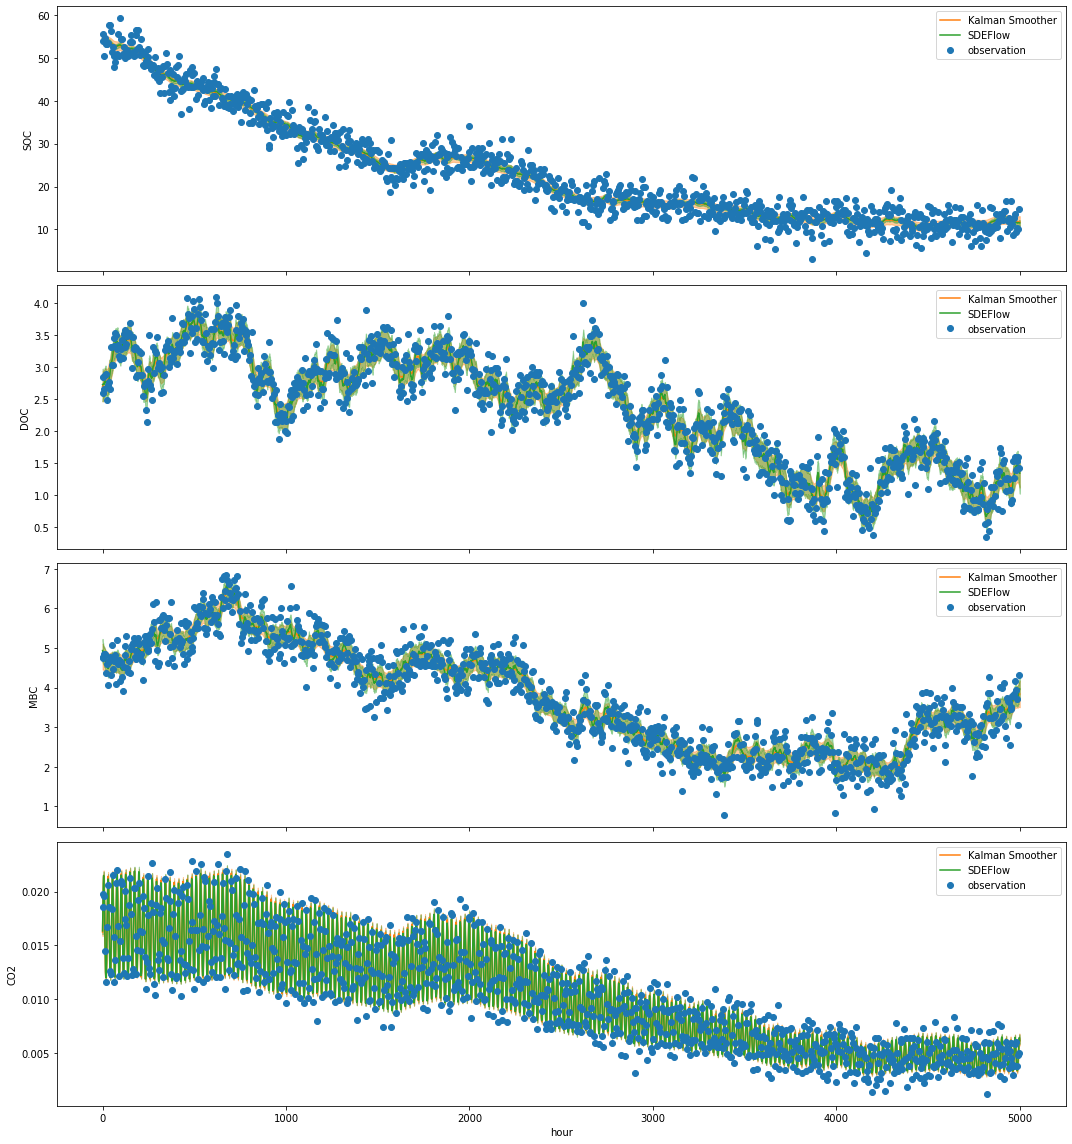

In [33]:
labels = ['Kalman Smoother', 'SDEFlow']
plot_states_post([kf, x1_5], T, dt, obs_vals, obs_times,
               state_dim=state_ndim, colors = [cm.tab10(i+1) for i in [0, 1]],
               labels=labels, alg_list=[3, 0])

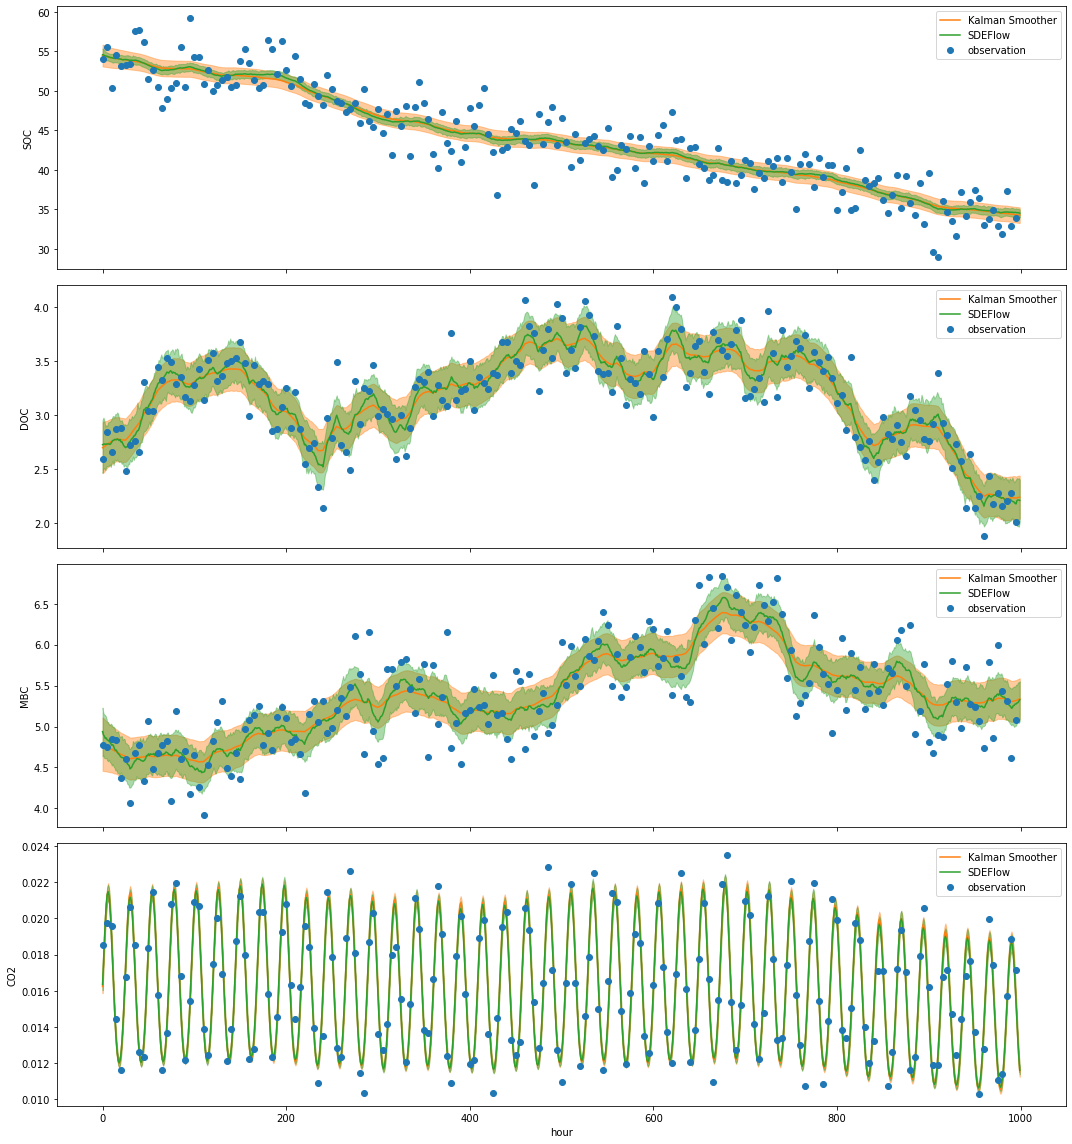

In [34]:
labels = ['Kalman Smoother', 'SDEFlow']
plot_states_post([kf, x1_5], T, dt, obs_vals, obs_times,
               state_dim=state_ndim, colors = [cm.tab10(i+1) for i in [0, 1]],
               labels=labels, alg_list=[3, 0], lidx=0, ridx=1000)

In [ ]:
labels = ['Kalman Smoother', 'SDEFlow 5-layer']
plot_states_post([kf, x2], T, dt, obs_vals, obs_times,
               state_dim=state_ndim, colors = [cm.tab10(i+1) for i in [0, 1]],
               labels=labels, alg_list=[3, 0], lidx=0, ridx=1000)

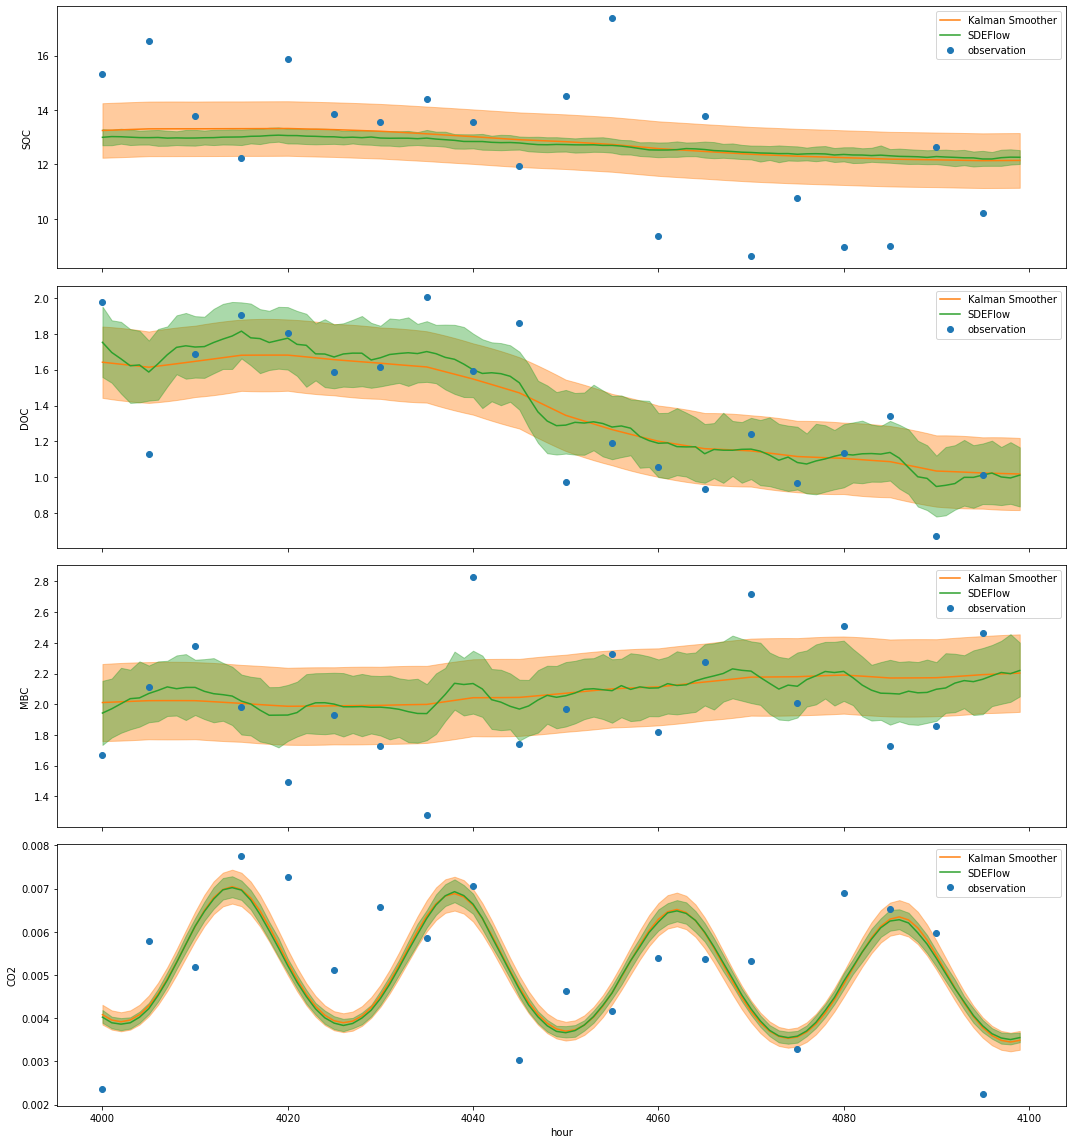

In [65]:
labels = ['Kalman Smoother', 'SDEFlow']
plot_states_post([kf, x], T, dt, obs_vals, obs_times,
               state_dim=state_ndim, colors = [cm.tab10(i+1) for i in [0, 1]],
               labels=labels, alg_list=[3, 0], lidx=4000, ridx=4100)

## Archive (ignore the rest)

In [ ]:
obs_model = ObsModel(TIMES = obs_times, DT = dt, MU = obs_vals.T, SCALE = obs_errors).to(device)
net = SDEFlow(device, obs_model, state_ndim, T, dt, N+1, num_layers = 5).to(device)
net.load_state_dict(torch.load(net_state_dict_file, map_location=device))

In [ ]:
SBM_SDE = torch.load(SBM_SDE_file, map_location=device)

In [ ]:
SBM_SDE.times.shape

In [ ]:
plot_path_post([kf, net], T, dt, obs_vals, obs_times,
               q_theta_raw_list=[None, q_theta], state_dim=state_ndim,
               colors = [cm.tab10(i+1) for i in [0, 1]],
               batch_size=batch_size, labels=labels, alg_list=[3, 0], lidx=0, ridx=100)

In [ ]:
def plot_post(data, state_idx, plot_sd=False, show_legend=True, labels=['SOC', 'DOC', 'MBC']):
    #plt.figure(figsize=(7, 6))
    obs = data[:, state_idx]
    mean_filter = kf.mu_filter[:, state_idx]
    mean_smooth = kf.mu_smooth[:, state_idx]
    
    if plot_sd:
        sd_filter = kf.sigma_filter[:, state_idx, state_idx].sqrt()
        #rv_filter = dist.normal.Normal(mean_filter, sd_filter)
        #plt.fill_between(T_span, rv_filter.icdf(torch.tensor(0.05)), rv_filter.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Filtered 5-95th percentile')
        plt.fill_between(T_span, mean_filter - 2*sd_filter, mean_filter + 2*sd_filter, alpha=0.5,
                         linewidth=0, label='Filtered $\\mu \pm 2\sigma$')
        
        sd_smooth = kf.sigma_smooth[:, state_idx, state_idx].sqrt()
        #rv_smooth = dist.normal.Normal(mean_smooth, sd_smooth)
        #plt.fill_between(T_span, rv_smooth.icdf(torch.tensor(0.05)), rv_smooth.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Smoothed 5-95th percentile')
        plt.fill_between(T_span, mean_smooth - 2*sd_smooth, mean_smooth + 2*sd_smooth, alpha=0.5,
                         linewidth=0, label='Smoothed $\\mu \pm 2\sigma$')
        
    plt.plot(T_span, mean_filter, label='Filtered mean')
    plt.plot(T_span, mean_smooth, label='Smoothed mean')
    plt.plot(obs_times, obs, linestyle='None', marker='o', label='Observed')
    
    plt.xlabel('Hour')
    plt.ylabel(labels[state_idx])
    plt.title('True posterior $q(x|\\theta, y)$')
    if show_legend: plt.legend()

In [ ]:
def plot_post(data, state_idx, plot_sd=False, show_legend=True, labels=['SOC', 'DOC', 'MBC']):
    #plt.figure(figsize=(7, 6))
    fig, axes = plt.subplots(3, 1, figsize=(6, 6))
    
    for i in range(ndim):
        
    obs = data[:, state_idx]
    mean_filter = kf.mu_filter[:, state_idx]
    mean_smooth = kf.mu_smooth[:, state_idx]
    
    if plot_sd:
        sd_filter = kf.sigma_filter[:, state_idx, state_idx].sqrt()
        #rv_filter = dist.normal.Normal(mean_filter, sd_filter)
        #plt.fill_between(T_span, rv_filter.icdf(torch.tensor(0.05)), rv_filter.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Filtered 5-95th percentile')
        plt.fill_between(T_span, mean_filter - 2*sd_filter, mean_filter + 2*sd_filter, alpha=0.5,
                         linewidth=0, label='Filtered $\\mu \pm 2\sigma$')
        
        sd_smooth = kf.sigma_smooth[:, state_idx, state_idx].sqrt()
        #rv_smooth = dist.normal.Normal(mean_smooth, sd_smooth)
        #plt.fill_between(T_span, rv_smooth.icdf(torch.tensor(0.05)), rv_smooth.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Smoothed 5-95th percentile')
        plt.fill_between(T_span, mean_smooth - 2*sd_smooth, mean_smooth + 2*sd_smooth, alpha=0.5,
                         linewidth=0, label='Smoothed $\\mu \pm 2\sigma$')
        
    plt.plot(T_span, mean_filter, label='Filtered mean')
    plt.plot(T_span, mean_smooth, label='Smoothed mean')
    plt.plot(obs_times, obs, linestyle='None', marker='o', label='Observed')
    
    plt.xlabel('Hour')
    plt.ylabel(labels[state_idx])
    plt.title('True posterior $q(x|\\theta, y)$')
    if show_legend: plt.legend()

In [ ]:
plot_post(obs_vals, 0, plot_sd=True)

In [ ]:
plot_post(obs_vals, 0)

In [ ]:
plot_post(obs_vals, 1, plot_sd=True)

In [ ]:
plot_post(obs_vals, 1)

In [ ]:
plot_post(obs_vals, 2, plot_sd=True)

In [ ]:
plot_post(obs_vals, 2)

### Debug

In [ ]:
kf.sigma_smooth[0]

In [ ]:
A[1] @ kf.mu_filter[0] + B @ u[1]

In [ ]:
kf.mu_filter[0]

## Testing the implementation: The constant velocity model

No need to worry about this part, it's for a different model! We used this for debugging purposes because we know the correct posterior for the model.

In [ ]:
import h5py

In [ ]:
sigma_v = 0.01
sigma_x = 0.01/3
sigma_y = 20

In [ ]:
track_file = h5py.File('track.mat', 'r')
track_file.keys()

In [ ]:
track_data = torch.tensor(track_file['data'], dtype=torch.float).squeeze()
track_data.shape

In [ ]:
mu0 = torch.tensor(track_file['x0'], dtype=torch.float).squeeze()
sigma0 = torch.tensor(track_file['P0'], dtype=torch.float)
mu0.shape, sigma0.shape

In [ ]:
T = len(track_data)
A = torch.tensor([[1, 1], [0, 1]], dtype=torch.float).unsqueeze(0) * torch.ones((T + 1, 1, 1))
Q = torch.tensor([[sigma_x, 0], [0, sigma_v]], dtype=torch.float)
C = torch.tensor([1, 0], dtype=torch.float).reshape((1, -1)).unsqueeze(0) * torch.ones((T + 1, 1, 1))
R = torch.tensor(sigma_y, dtype=torch.float)

In [ ]:
B, D = torch.eye(2), torch.ones(2)

In [ ]:
kf = KalmanFilter(A, B, C, D, Q, R, T - 1, init_mu=mu0, init_sigma=sigma0)
kf.forward(track_data)
kf.backward()

In [ ]:
T_span = torch.arange(100)
obs_times = torch.arange(100)
plot_post(track_data.unsqueeze(1), 0, plot_sd=True, labels=['State', 'State 2'])

In [ ]:
z = torch.arange(15).reshape((5, 3))
mu = torch.arange(15).reshape((5, 3))
z.shape, mu.shape

In [ ]:
mu_co2 = torch.einsum('ij,ij->i', z, mu)

In [ ]:
T = z.shape[0]
[z[i] @ mu[i] for i in range(T)]

In [ ]:
mu

In [ ]:
sigma = torch.arange(45).reshape((5, 3, 3))
torch.einsum('ij,ijk,ik->i', z, sigma, z)

In [ ]:
[z[i] @ sigma[i] @ z[i] for i in range(T)]

In [ ]:
z[0].reshape((1, -1)) @ sigma[0] @ z[0].reshape((-1, 1))

In [ ]:
z[0], sigma[0]